In [5]:
from wmi_backend import *
from wmi_decompositions import *

In [27]:
import numpy as np
from qiskit import *
from qiskit.circuit.library import XXPlusYYGate
from util import *

class FermiHubbard_2D():
    """
        Implements the 2D Fermi Hubbard model on a square lattice
    """
    def __init__(
        self,
        u,              # on-site Couloumb repulsion energy, describing the energy cost associated with two fermions with opposite spins occupying the same site
        t,              # hopping energy, describing the amplitude for particles to hop from one site to its neighboring site
        lattice_size    # dimensions of the lattice (horizontal, vertical)

    ) -> None:
        self.u = u
        self.t = t
        self.Nx, self.Ny = lattice_size
        self.num_sites = self.Nx * self.Ny
        self.num_qubits = 2*self.num_sites

    @property
    def Hamiltonian(self):
        """
            Computes the exact spin Hamiltonian of the 2D Fermi Hubbard model after the Jordan-Wigner transformation.
            H_FH = 1/4 u * \sum_{j=1}^n (I_{j,↑} I_{j,↓} - I_{j,↑} Z_{j,↓} - Z_{j,↑} I_{j,↓} + Z_{j,↑} Z_{j,↓})
                    - \sum_{<i,j>} \sum_{σ ∈ [↑,↓]} -1/2 * (X_{i,σ} (⊗_{k=i+1}^{j-1} Z_{k,σ}) X_{i,σ}  +  Y_{i,σ} (⊗_{k=i+1}^{j-1} Z_{k,σ}) Y_{i,σ})

            1---2---3               
            |   |   |         
            4---5---6   ==>  [1↑]---[1↓]---[2↑]---[2↓]--- ... ---[9↑]---[9↓]
            |   |   |
            7---8---9
        """
        H_1 = np.zeros((2**nsysqubits, 2**nsysqubits), dtype = 'complex_')
        H_2 = np.zeros((2**nsysqubits, 2**nsysqubits), dtype = 'complex_')

        H_FH = H_1 + H_2

        return H_FH

    def Trotterization(
            self,
            delta_t = 1,
            n = 2,
            control_free = False
    ):
        """
            Build the circuit for the second-order Trotter approximation of the Fermi Hubbard Hamiltonian.

            exp(-i*Δt*H_FH) = exp(-i*Δt*(H_1 + H_2))
                            ≈ [exp(-i*Δt/2 * H_1) * exp(-i*Δt * H_2) * exp(-i*Δt * H_1)]^n

            Input:
                delta_t
                n
                control_free
            Output:
                circuit of the trotterized Fermi Hubbard Hamiltonian
        """
        trotter_order = 2
        
        def H_1():
            """
                Implementation of the first term of the 2D Fermi Hubbard Hamiltonian.
                This term is the interaction term.

                exp(-i*Δt/2 * H_1) = exp(-i*Δt*1/8*u * \sum_j ( (I_{j,↑} - Z_{j,↑}) * (I_{j,↓} - Z_{j,↓}))
                                       = \prod_j CP(-1/2*Δt*u)
                                                      
                ↑ 0: ─■───────────────────────────────
                      │                               
                ↑ 1: ─┼──────────■────────────────────
                      │          │                    
                ↑ 2: ─┼──────────┼──────────■─────────
                      │CP        │          │         
                ↓ 0: ─■──────────┼──────────┼─────────
                                 │CP        │         
                ↓ 1: ────────────■──────────┼─────────
                                            │CP       
                ↓ 2: ───────────────────────■─────────
            """
            λ = - self.u * delta_t / 2 
            spin_up = QuantumRegister(self.num_sites, '↑')
            spin_down = QuantumRegister(self.num_sites, '↓')
            circuit = QuantumCircuit(spin_up, spin_down)
            for j in range(self.num_sites):
                circuit.cp(λ, spin_up[j], spin_down[j])
            return circuit
        
        def H_2():                                                                                                                                             
            """
                Implementation of the second term of the 2D Fermi Hubbard Hamiltonian.
                This term is the kinetic hopping term.

                exp(-i*Δt * H_2) = exp(-i*Δt * -t * \sum_{<i,j>,σ} h_{i,j,σ})
                                 = \prod_{<i,j>,σ} [
                                    exp(-i*Δt * -t/2 * (X_{i,σ} ⊗ Z_{i+1,σ} ⊗ Z_{i+2,σ} ⊗ ... ⊗ Z_{j-1,σ} ⊗X_{j,σ} ))
                                    * exp(-i*Δt * -t/2 * (Y_{i,σ} ⊗ Z_{i+1,σ} ⊗ Z_{i+2,σ} ⊗ ... ⊗ Z_{j-1,σ} ⊗ Y_{j,σ} )) ]            
            """

            def sigma_gate(len):
                """""
                    Implementation of the gate used to 
                    exp(-i*Δt*(-t)/n * h_{i,j,σ})
                     = exp(-i*Δt*(-t)/n * (X_{i,σ} ⊗ Z_{i+1,σ} ⊗ Z_{i+2,σ} ⊗ ... ⊗ Z_{j-1,σ} ⊗X_{j,σ} ))
                     * exp(-i*Δt*(-t)/n * (Y_{i,σ} ⊗ Z_{i+1,σ} ⊗ Z_{i+2,σ} ⊗ ... ⊗ Z_{j-1,σ} ⊗ Y_{j,σ} ))

                     ┌─────┐         ┌─────┐   ┌─────┐  
                    ─┤     ├──      ─┤     ├───┤     ├──
                    ─┤  Σ  ├──  =   ─┤ RXX ├───┤ RYY ├──
                    ─┤     ├──      ─┤     ├───┤     ├──
                    ─┤     ├──      ─┤     ├───┤     ├──
                     └─────┘         └─────┘   └─────┘          

                    ┌─────────┐                                       ┌──────────┐  ┌─────────┐                                       ┌──────────┐
                    ┤ Ry(π/2) ├──■─────────────────────────────────■──┤ Ry(-π/2) ├──┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├
                    └─────────┘┌─┴─┐                             ┌─┴─┐└──────────┘  └─────────┘┌─┴─┐                             ┌─┴─┐└──────────┘
                    ───────────┤ X ├──■───────────────────────■──┤ X ├─────────────────────────┤ X ├──■───────────────────────■──┤ X ├────────────
                               └───┘┌─┴─┐                   ┌─┴─┐└───┘                         └───┘┌─┴─┐                   ┌─┴─┐└───┘            
                    ────────────────┤ X ├──■─────────────■──┤ X ├───────────────────────────────────┤ X ├──■─────────────■──┤ X ├─────────────────
                    ┌─────────┐     └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     ┌──────────┐  ┌─────────┐     └───┘┌─┴─┐┌───────┐┌─┴─┐└───┘     ┌──────────┐ 
                    ┤ Ry(π/2) ├──────────┤ X ├┤ Rz(θ) ├┤ X ├──────────┤ Ry(-π/2) ├──┤ Rx(π/2) ├──────────┤ X ├┤ Rz(θ) ├┤ X ├──────────┤ Rx(-π/2) ├
                    └─────────┘          └───┘└───────┘└───┘          └──────────┘  └─────────┘          └───┘└───────┘└───┘          └──────────┘
                """
                θ = -self.t * delta_t
                q = QuantumRegister(len, 'q')
                circuit = QuantumCircuit(q)

                # exp(XZZ...ZZX)
                circuit.ry(np.pi/2, 0)
                circuit.ry(np.pi/2, len-1)
                for i in range(0, len-1):
                    circuit.cnot(i, i+1)
                circuit.rz(θ, len-1)
                for i in reversed(range(0, len-1)):
                    circuit.cnot(i, i+1)
                circuit.ry(-np.pi/2, 0)
                circuit.ry(-np.pi/2, len-1)
                # exp(YZZ...ZZY)
                circuit.rx(np.pi/2, 0)
                circuit.rx(np.pi/2, len-1)
                for i in range(0, len-1):
                    circuit.cnot(i, i+1)
                circuit.rz(θ, len-1)
                for i in reversed(range(0, len-1)):
                    circuit.cnot(i, i+1)
                circuit.rx(-np.pi/2, 0)
                circuit.rx(-np.pi/2, len-1)

                gate = circuit.to_gate(label="Σ")
                return gate

            spin_up = QuantumRegister(self.num_sites, '↑')
            spin_down = QuantumRegister(self.num_sites, '↓')
            circuit = QuantumCircuit(spin_up, spin_down)
            # horizontal hopping
            for i in range(0, self.num_sites - 1):
                if (i+1) % self.Nx != 0:
                    circuit.append(XXPlusYYGate(-2*delta_t, 0), [spin_up[i], spin_up[i+1]])
                    circuit.append(XXPlusYYGate(-2*delta_t, 0), [spin_down[i], spin_down[i+1]])
            # vertical hopping
            for i in range(0, self.num_sites - self.Nx):
                circuit.append(sigma_gate(self.Nx + 1), [spin_up[j] for j in range(i, i + self.Nx + 1)])
                circuit.append(sigma_gate(self.Nx + 1), [spin_down[j] for j in range(i, i + self.Nx + 1)])
            return circuit
        
        spin_up = QuantumRegister(self.num_sites, '↑')
        spin_down = QuantumRegister(self.num_sites, '↓')
        if not control_free:
            circuit = QuantumCircuit(spin_up, spin_down)
            for _ in range(n):
                circuit.compose(H_1(), spin_up[:] + spin_down[:], inplace=True)
                circuit.compose(H_2(), spin_up[:] + spin_down[:], inplace=True)
                circuit.compose(H_1(), spin_up[:] + spin_down[:], inplace=True)
        else:
            anc = QuantumRegister(1, 'ancilla')
            circuit = QuantumCircuit(spin_down, spin_up, anc)
            for _ in range(n):
                circuit.compose(H_1(), spin_up[:] + spin_down[:], inplace=True)
                circuit.compose(H_2(), anc[:] + spanc[:] + in_up[:] + spin_down[:], inplace=True)
                circuit.compose(H_1(), anc[:] + spin_up[:] + spin_down[:], inplace=True)
        return circuit

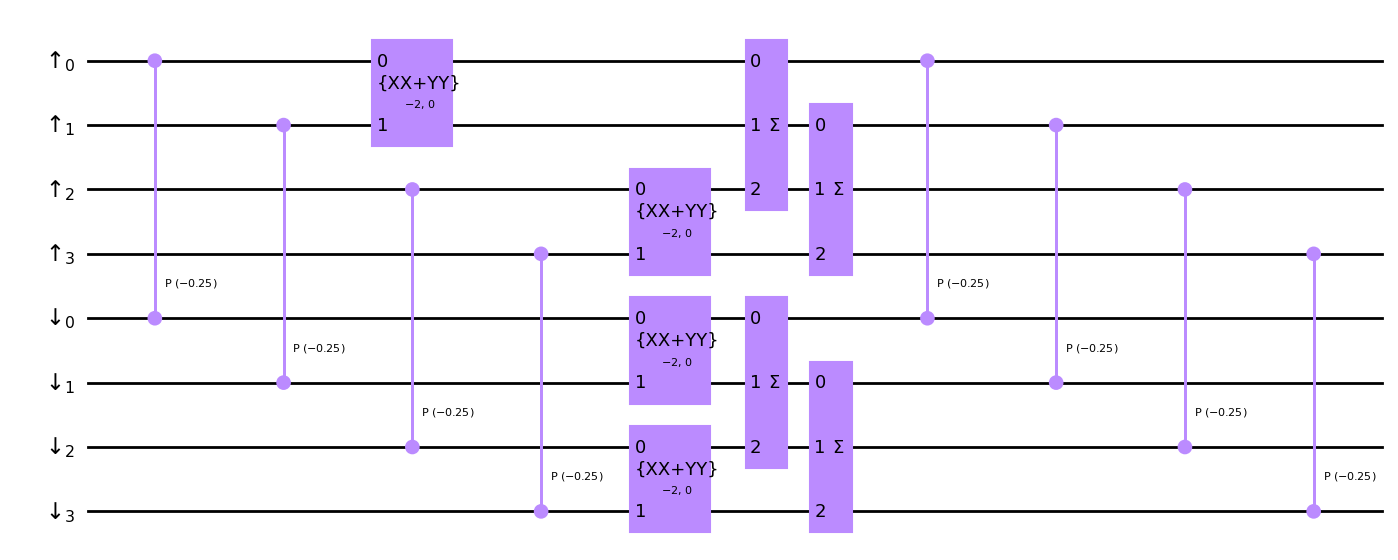

In [28]:
delta_t = 1

fh = FermiHubbard_2D(t=1, u=0.5, lattice_size=(2,2))
fh_qc = fh.Trotterization(delta_t, 1)
fh_qc.draw("mpl")

In [29]:
backend = FakeWMI()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['sx', 'measure', 'cp', 'x', 'iswap', 'y', 'xx_plus_yy']>

In [ ]:
# Transpile to WMI hardware
test_circ = transpile(
    fh_qc,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()